Detect spontaneous synaptic transmission and parameters.

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip, spon_ana
import seaborn as sns
import pickle
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('classic')

% matplotlib inline
# % matplotlib notebook

%load_ext autoreload
% autoreload 2

In [2]:
data = pd.read_pickle('/data/ana_post_EI_50Hz_reci')

In [3]:
data

,Before,After,File name,elimi,spon_elimi_bef,spon_elimi_aft
36,"{'raw_onset_tau': [0.0004, nan, 0.000475, 0.00...","{'raw_onset_tau': [0.000425, 0.000375, 0.0004,...",2017032701,60,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 3...",[]
37,"{'raw_onset_tau': [0.000325, nan, 0.00025, 0.0...","{'raw_onset_tau': [0.000275, 0.0003, nan, 0.00...",2017032802,60,[],"[126, 128, 130, 137, 139, 141, 146, 150]"
38,"{'raw_onset_tau': [0.000425, 0.00035, nan, nan...","{'raw_onset_tau': [0.000375, 0.0004, 0.00035, ...",2017032905,20,"[9, 10, 22, 29, 30, 32, 33, 36, 37]","[6, 8, 11, 14, 22, 27, 29]"
39,"{'raw_onset_tau': [0.00035, 0.000675, 0.000575...","{'raw_onset_tau': [0.000375, 0.00045, 0.0008, ...",2017053102,20,"[19, 22, 26, 39]","[14, 19, 24, 25, 34, 36]"
172,"{'raw_onset_tau': [nan, nan, nan, 0.000275, 0....","{'raw_onset_tau': [nan, nan, 0.0005, 0.00025, ...",2018032301,40,"[0, 1, 4, 8, 10, 19, 26, 29, 30, 31]","[37, 41, 42, 53, 62, 69, 70, 72, 87, 88, 92]"
175,"{'raw_onset_tau': [nan, nan, nan, nan, nan, na...","{'raw_onset_tau': [0.000275, nan, nan, 0.00042...",2018032802,30,[23],"[51, 60, 62]"


In [9]:
# post_2Hz_reci.index
def spon_psc_ana(df, filename, bef_aft_choice='before', ifsave=True, ifTrace_ana=True, div_slope=2, thres=4):

    for choice in list(df.index):

        if bef_aft_choice == 'before':
            spon_list = df.Before.loc[choice]['spon_trace'].copy()
            elimi_list = df.loc[choice]['spon_elimi_bef'].copy()
            spon_list = spon_ana.pop_Spon_Trace(spon_list, elimi_list)
            spon_trace = -1 * np.hstack(spon_list)

            plt.figure()
            plt.plot(spon_trace)

            # Obtain the template
            popt, xdata, template = spon_ana.template_Gen(df, index=choice, bef_aft=0)
        else:
            spon_list = df.After.loc[choice]['spon_trace'].copy()
            elimi_list = df.loc[choice]['spon_elimi_aft'].copy()

            range_idx = spon_ana.post_bef_end(df.loc[choice].elimi)
            spon_list = [spon_list[i] for i in range_idx]
            elimi_list = list(np.array(elimi_list) - range_idx[0])

            spon_list = spon_ana.pop_Spon_Trace(spon_list, elimi_list)
            spon_trace = -1 * np.hstack(spon_list)

            plt.figure()
            plt.plot(spon_trace)

            # Obtain the template
            popt, xdata, template = spon_ana.template_Gen(df, index=choice, bef_aft=1)


        plt.figure()
        plt.plot(template)
        plt.plot(spon_ana.fun_exp(xdata, *popt), label='raw fit')
        plt.plot(spon_ana.fun_exp(xdata, *popt*2), label='scale up')
        plt.plot(spon_ana.fun_exp(xdata, *popt/div_slope), label='scale down')
        plt.legend()

        psc_dic = {}
        psc_loc_track = []
        
        for i in range(len(spon_list)):
            # detection locations of PSCs
            psc_loc_raw = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt), thres=thres)
            psc_loc_up = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt*2), thres=thres)
            psc_loc_down = spon_ana.spon_detect(spon_list[i], spon_ana.fun_exp(xdata, *popt/div_slope), thres=thres)
            psc_list= list(set(np.concatenate([psc_loc_raw,psc_loc_up, psc_loc_down])))
            psc_list.sort()
            psc_loc = np.array(psc_list).reshape(1,-1)
            # Obtain amplitude, decay, onset time constant of each psc
            psc_loc_track.append(psc_loc)
                        
            if ifTrace_ana:
                psc_dic[i] = spon_ana.psc_search(spon_list[i], psc_loc)

        # Save the results for future analysis
        if ifsave:
            with open('/data/' + filename + '_'+ bef_aft_choice + '_{}'.format(choice), 'wb') as fp:
                pickle.dump(psc_dic, fp)

            print('saving psc data from %d ...' % choice)
        
# Visualize each synaptic response
#         for j in range(len(psc_dic)):
#             for i in range(len(psc_dic[j])):
#                 plt.figure()
#                 plt.plot(psc_dic[j][i]['trace'])
#                 plt.title("%d th resp, %d th trace, decay=%s, error=%0.5f  " % (j, i, psc_dic[j][i]['decay_tau'], psc_dic[j][i]['fit_error']))
#                 plt.plot(np.arange(len(psc_dic[j][i]['decay_fit']))+np.argmax(psc_dic[j][i]['trace']), psc_dic[j][i]['decay_fit'])
#                 plt.ylim([0,1e-10])
                
    return spon_list, psc_loc_track

In [14]:
spon_list, psc_loc_track = spon_psc_ana(data, 'psc_non_asso_50Hz_slope4_thres2.5', bef_aft_choice='before', div_slope=4, thres=2.5)

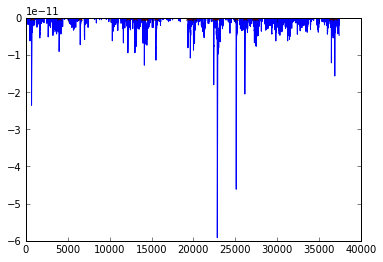

In [11]:
trace_id = 0
plt.plot(spon_list[trace_id])
plt.plot(psc_loc_track[trace_id], np.zeros(len(psc_loc_track[trace_id])), 'r*')

In [12]:
# spon_psc_ana(data, 'psc_non_asso_AM251', bef_aft_choice='before')

In [15]:
spon_psc_ana(data, 'psc_non_asso_50Hz_slope4_thres2.5', bef_aft_choice='after', div_slope=4, thres=2.5)